In [1]:
import numba
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv

In [4]:
def test(a):
    a[0] = 1
    a *= 2

a = np.array([0,2,3])
test(a)
a

array([2, 4, 6])

In [2]:
@numba.njit
def double(a):
    return 2.0*a

In [6]:
from typing import Callable

isinstance(double, Callable)

True

In [7]:
numba.njit()(double.py_func)

CPUDispatcher(<function double at 0x000001F11FA269D0>)

In [90]:
@numba.njit(parallel=True)
def parallel(x):
    y = np.empty_like(x)
    n = x.shape[0]

    for i in numba.prange(n):
        y[i] = double(x[i])
    
    return y

@numba.njit(fastmath=True)
def serial(x):
    y = np.empty_like(x)
    n = x.shape[0]

    for i in range(n):
        y[i] = double(x[i])
    
    return y

def not_jit(x):
    y = np.empty_like(x)
    n = x.shape[0]

    for i in range(n):
        y[i] = double(x[i])
    
    return y

In [39]:
x = np.ndarray((10000000))

parallel(x)
serial(x)

print()

In [86]:
results = [[],[]]
sizes = []

functions = [parallel, serial]


for i in range(1, int(1e10), int(1e9)):
    x = np.ndarray((i))

    for j in range(2):
        e1 = cv.getTickCount()
        functions[j](x)
        e2 = cv.getTickCount()

        time = (e2-e1)/cv.getTickFrequency()

        results[j].append(time)
    sizes.append(i)

MemoryError: Unable to allocate 22.4 GiB for an array with shape (3000000001,) and data type float64

In [74]:
results = np.array(results)
sizes = np.array(sizes)

In [96]:
%matplotlib qt

plt.plot(sizes, results[0])
plt.plot(sizes, results[1])

plt.legend(["Parallel", "Serial"])

plt.show()

In [95]:
x = np.ndarray((10))
numba.njit(parallel=True)(not_jit)(x)

C:\Python38\lib\site-packages\numba\typed_passes.py:292: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-90-8a56f9f97449>", line 21:

def not_jit(x):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


array([0., 0., 2., 0., 2., 2., 0., 2., 0., 0.])

In [40]:
%timeit parallel(x)

17.6 ms ± 309 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
%timeit serial(x)

27.2 ms ± 793 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
%timeit parallel(x)

17.5 ms ± 357 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [47]:
%timeit parallel(x)

17.7 ms ± 375 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
parallel.parallel_diagnostics(level=4)

 
 Parallel Accelerator Optimizing:  Function parallel, <ipython-
input-28-550094ee11dc> (1)  


Parallel loop listing for  Function parallel, <ipython-input-28-550094ee11dc> (1) 
---------------------------------|loop #ID
@numba.njit(parallel=True)       | 
def parallel(x):                 | 
    y = np.empty_like(x)         | 
    n = x.shape[0]               | 
                                 | 
    for i in numba.prange(n):----| #7
        y[i] = double(x[i])      | 
                                 | 
    return y                     | 
--------------------------------- Fusing loops ---------------------------------
Attempting fusion of parallel loops (combines loops with similar properties)...
----------------------------- Before Optimisation ------------------------------
--------------------------------------------------------------------------------
------------------------------ After Optimisation ------------------------------
Parallel structure is already optimal.
--------

In [97]:
x = np.ndarray((1000))

In [99]:
%timeit not_jit(x)

315 µs ± 3.08 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [102]:
@numba.njit
def test(x):
    not_jit(x)

In [103]:
%timeit not_jit(x)
%timeit test(x)
%timeit serial(x)

315 µs ± 5.09 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'not_jit':[0m [1m[1mcannot determine Numba type of <class 'function'>[0m
[1m
File "<ipython-input-102-95d4c6051fa1>", line 3:[0m
[1mdef test(x):
[1m    not_jit(x)
[0m    [1m^[0m[0m
[0m

In [104]:
@numba.njit
def func(a, b, c):
    return a+b+c

In [109]:
func(**{"a":1, "b":2, "c":3})

6

In [20]:
def sum(x):
    sum = 0
    for key in x:
        sum += x[key]

In [5]:
x = numba.typed.Dict()
sum(x)

TypeError: invalid operation on untyped dictionary

In [14]:
numba.typed.Dict.empty(key_type=numba.types.unicode_type, value_type=numba.targets.registry.CPUDispatcher)

AttributeError: type object 'CPUDispatcher' has no attribute 'name'

In [24]:
@numba.njit
def test():
    d = dict()
    d["a"] = sum
    return d
test()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'sum':[0m [1m[1mcannot determine Numba type of <class 'function'>[0m
[1m
File "<ipython-input-24-554508cf7adb>", line 4:[0m
[1mdef test():
    <source elided>
    d = dict()
[1m    d["a"] = sum
[0m    [1m^[0m[0m
[0m

In [49]:
@numba.jit(parallel=True)
def test2(x, op):
    n = x.shape[0]
    for key in op:
        for i in numba.prange(n):
            op[key](x[i])

In [47]:
@numba.njit
def op1(x):
    print(x[0])
    return x

@numba.njit
def op2(x):
    return 2*x

ops = {"op1":op1, "op2":op2}

x = np.ndarray((10,10))

for i in range(10):
    x[i][0] = i

test2(x, ops)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1m[1] During: typing of argument at <ipython-input-46-06bebc64df4a> (3)[0m
[1m
File "<ipython-input-46-06bebc64df4a>", line 3:[0m
[1mdef test2(x, op):
[1m    n = x.shape[0]
[0m    [1m^[0m[0m

This error may have been caused by the following argument(s):
- argument 1: [1mcannot determine Numba type of <class 'dict'>[0m


In [50]:
test2.parallel_diagnostics(level=4)

In [52]:
dtype = np.dtype([("a", np.float32, 10)])

In [60]:
@numba.njit
def func(dtype):
    np.ones(10, dtype=dtype)

func(np.float32)

In [62]:
import numba as nb

def pyObjToNumbaObj(pyObj):
    if type(pyObj)==dict:
        pyDict=pyObj
        keys=list(pyDict.keys())
        values=list(pyDict.values())
        if type(keys[0]) == str:nbhKeytype = nb.types.string
        elif type(keys[0]) == int:nbhKeytype = nb.types.int32
        elif type(keys[0]) == float: nbhKeytype = nb.types.float32
        if type(values[0])==int:
            nbh=nb.typed.Dict.empty(nbhKeytype,nb.types.int32)
            for i,key in enumerate(keys):nbh[key]=values[i]
            return(nbh)
        elif type(values[0])==str:
            nbh=nb.typed.Dict.empty(nbhKeytype,nb.types.string)
            for i,key in enumerate(keys):nbh[key]=values[i]
            return(nbh)
        elif type(values[0]) == float:
            nbh=nb.typed.Dict.empty(nbhKeytype,nb.types.float32)
            for i,key in enumerate(keys):nbh[key]=values[i]
            return(nbh)
        elif type(values[0])==dict:
            for i,subDict in enumerate(values):
                subDict=pyObjToNumbaObj(subDict)
                if i==0:nbh=nb.typed.Dict.empty(nbhKeytype,nb.typeof(subDict))
                nbh[keys[i]]=subDict
            return(nbh)
        elif type(values[0])==list:
            for i, subList in enumerate(values):
                subList=pyObjToNumbaObj(subList)
                if i==0:nbh=nb.typed.Dict.empty(nbhKeytype,nb.typeof(subList))
                nbh[keys[i]] = subList
            return(nbh)
    elif type(pyObj)==list:
        pyList=pyObj
        data = pyList[0]
        if type(data) == int:
            nbs = nb.typed.List.empty_list(nb.types.int32)
            for data_ in pyList: nbs.append(data_)
            return (nbs)
        elif type(data) == str:
            nbs = nb.typed.List.empty_list(nb.types.string)
            for data_ in pyList: nbs.append(data_)
            return (nbs)
        elif type(data) == float:
            nbs = nb.typed.List.empty_list(nb.types.float32)
            for data_ in pyList: nbs.append(data_)
            return (nbs)
        elif type(data) == dict:
            for i,subDict in enumerate(pyList):
                subDict = pyObjToNumbaObj(subDict)
                if i == 0: nbs = nb.typed.List.empty_list(nb.typeof(subDict))  
                nbs.append(subDict)
            return(nbs)
        elif type(data) == list:
            for i,subList in enumerate(pyList):
                subList=pyObjToNumbaObj(subList)
                if i==0: nbs = nb.typed.List.empty_list(nb.typeof(subList))  
                nbs.append(subList)
            return(nbs)

In [68]:
a = pyObjToNumbaObj({"a":10.0, "b": 2.0})

In [70]:
@numba.njit
def func(a, b):
    return a-b

func(**a)

8.0

In [91]:
a = pyObjToNumbaObj({"a":10.0, "b": 2.0})

@numba.njit
def test():
    
    return "a"

test()

'a'

In [80]:
dict_to_array = np.array(list({"a":1}.values()), dtype={"names":["a"], "formats":[float]})

dict_to_array[0]["a"]

1.0

In [84]:
mut_param_dtype = np.dtype([("rate", float), ("range", float), ("gene", float)])

mut_params_dtype = np.dtype({"names":["ch1", "ch2"], "formats":2*[mut_param_dtype]})

In [87]:
params = np.ndarray(1, dtype=mut_params_dtype)

In [95]:
@numba.njit
def func(params):
    return params[0]()

In [77]:
list({"a":1}.items())

[('a', 1)]

In [89]:
mut_params_dtype

dtype([('ch1', [('rate', '<f8'), ('range', '<f8'), ('gene', '<f8')]), ('ch2', [('rate', '<f8'), ('range', '<f8'), ('gene', '<f8')])])

In [96]:
func([test])

C:\Python38\lib\site-packages\numba\ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'params' of function 'func'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-95-68e28ce0ad5d>", line 2:
@numba.njit
def func(params):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


'a'

In [6]:
@numba.experimental.jitclass
class Test:

    def __init__(self):
        pass

    def sum(self, a, b):
        result = np.empty_like(a, dtype=np.int64)
        
        for i in numba.prange(len(a)):
            result[i] = a[i]+b[i]
        
        return result

In [13]:
@numba.njit
def aaa(a):
    result = np.empty_like(a, dtype=np.int64)

    return result

aaa(a)

array([-3761688987579986997, -3761688987579986997, -3761688987579986997,
       -3761688987579986997, -3761688987579986997], dtype=int64)

In [7]:
test = Test()

a = np.array([1,2,3,4,5], dtype=np.int64)
b = np.array([5,4,3,2,1], dtype=np.int64 )

test.sum(a, b)

array([6, 6, 6, 6, 6], dtype=int64)

In [20]:
import numpy as np
from numpy.typing import ArrayLike

class Population:
    """
    Store the data from a generation of the experiment.

    :ivar names: Names of the chromossomes
    :type names: numpy.ndarray of strings
    
    :ivar mutation_op: Mutation operators
    :type mutation_op: list of functions

    :ivar mutation_params: Mutation parameters
    :type mutation_params: dict of dicts

    :ivar crossover_op: Crossover operators
    :type crossover_op: list of functions

    :ivar crossover_params: Crossover parameters
    :type crossover_params: dict of dicts

    :ivar selection_op: Selection operator
    :type selection_op: function

    :ivar dtype: individual's dtype
    :type dtype: numpy.dtype

    """

    def __init__(self, chromossome_sizes:ArrayLike, n_chromossome:int=1, types:list=[np.float32], names:list=[]):
        dtype = []

        chromossome_sizes = np.asarray(chromossome_sizes)

        self.names = []
        self.mutation_op = {}
        self.mutation_params = {}

        self.crossover_op = {}
        self.crossover_params = {}

        for i in range(n_chromossome):
            name = "chr"+str(i)
            if len(names)-1 >= i:
                name = names[i]
            self.names.append(name)

            size = np.atleast_1d(chromossome_sizes[i])
            size = tuple(size)

            dtype.append((name, types[i], size))


            self.mutation_params[name] = {"existence_rate":1.0, "gene_rate": 0.0, "range": (0.0, 1.0)}
            self.crossover_params[name] = {}


        self.names = np.asarray(self.names)

        self.dtype = np.dtype(dtype)
        self.population = np.empty(2, dtype=self.dtype)


    def set_mutation(self, chromossome_name="", chromossome_index=-1, operator=None, parameters=None):
        if chromossome_name == "":
            chromossome_name = self.names[chromossome_index]
        
        if operator is not None:
            self.mutation_op[chromossome_name] = operator

        if parameters is not None:
            self.mutation_params[chromossome_name] - parameters
    
    def set_crossover(self, chromossome_name="", chromossome_index=-1, operator=None, parameters=None):
        if chromossome_name == "":
            chromossome_name = self.names[chromossome_index]
        
        if operator is not None:
            self.crossover_op[chromossome_name] = operator

        if parameters is not None:
            self.crossover_params[chromossome_name] - parameters
        
    def set_selection(self, operator):
        self.selection_op = operator


In [22]:
pop = Population([1,1,1], 3, [np.float32, np.float32, np.float32])

In [33]:
pop.population

array([([0.  ], [0.], [0.   ]), ([1.75], [0.], [1.875])],
      dtype=[('chr0', '<f4', (1,)), ('chr1', '<f4', (1,)), ('chr2', '<f4', (1,))])

In [51]:
np.empty(2, np.float64).dtype

dtype('float64')

In [52]:
len(pop.population.dtype)

3

In [55]:
all_names = pop.population.dtype.names

In [36]:
pop.population["chr0"].flatten()

array([0.  , 1.75], dtype=float32)

In [54]:
np.asarray(pop.population).dtype

dtype([('chr0', '<f4', (1,)), ('chr1', '<f4', (1,)), ('chr2', '<f4', (1,))])

In [59]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

['chr2', 'chr1']

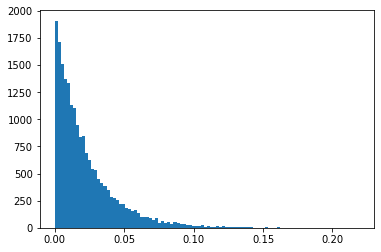

In [66]:
import numpy as np
import matplotlib.pyplot as plt

hist = []

for i in range(20000):
    j = 0
    while(np.random.rand() < 0.999):
        j +=1
    hist.append(j/45544)

hist = np.array(hist)

plt.hist(hist, bins=100)
plt.show()

In [67]:
np.sum(hist>=0.1)/len(hist)

0.0113

0.999 - 0.011 - 1,1%
0.99 - 0.0 - 0%

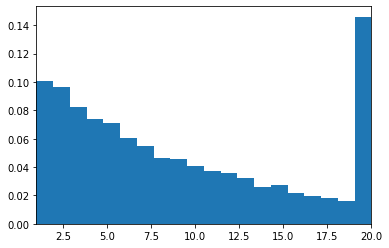

In [36]:
import numpy as np
import matplotlib.pyplot as plt

n_gene = 20

def sum_mutation(existence_rate:float, gene_rate:float):
    hist = []

    for i in range(10000):
        first = True
        count = 0
        if np.random.rand() < existence_rate:
            while (first or np.random.rand() < gene_rate) and count < n_gene:
                first = False
                count += 1
        
        hist.append(count)

    return hist

hist = sum_mutation(1.0, 0.9)



plt.hist(hist, bins=n_gene, density=True)
plt.xlim(1.0, n_gene)
plt.show()

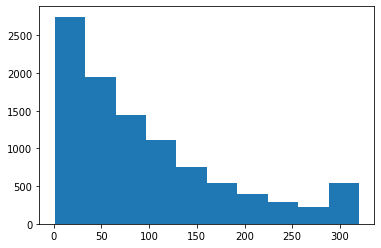

In [8]:
((24*20)+(20*20)+(20*4))/3

320.0

In [14]:
24*20

480

In [19]:
20*20

400